In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import ecgdetectors
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats

import src.data
import utils
import utils.wavelet
import utils.data
import utils.data.augmentation
import utils.visualization
import utils.visualization.plot
import utils.torch
import utils.torch.nn
import utils.torch.nn as nn
import utils.torch.loss
import utils.torch.train
import utils.torch.data
import utils.torch.preprocessing
import utils.torch.models
import utils.torch.models.lego
import utils.torch.models.variational
import utils.torch.models.classification

from utils.signal import StandardHeader

def smooth(x: np.ndarray, window_size: int, conv_mode: str = 'same'):
    x = np.pad(np.copy(x),(window_size,window_size),'edge')
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x

In [ ]:
def dice(mask_1, mask_2):
    intersection = (mask_1 * mask_2).sum()
    union = mask_1.sum() + mask_2.sum()
    return 2.*intersection/(union + np.finfo('double').eps)


In [310]:
gt_on  = utils.load_data('/home/guille/Escritorio/Ruben/QRS/onsets.csv')
gt_off = utils.load_data('/home/guille/Escritorio/Ruben/QRS/offsets.csv')
pr_on  = utils.load_data('/home/guille/Escritorio/Ruben/QRS/onsets.csv')
pr_off = utils.load_data('/home/guille/Escritorio/Ruben/QRS/offsets.csv')

In [311]:
# Jitter on on/off - differ in mean/std for delineation metrics
for k in pr_on:
    pr_on[k]  = np.clip(pr_on[k]+np.random.randint(0,2),  a_min=0, a_max=np.max(pr_on[k]))
    pr_off[k] = np.clip(pr_off[k]+np.random.randint(0,2), a_min=0, a_max=np.max(pr_off[k]))

In [312]:
# Mark to delete
deleted = {}

for k in pr_on:
    indices = np.arange(pr_on[k].size)
    indices = np.random.permutation(indices)
    deleted_indices = indices[:np.random.randint(0,indices.size//2)]
    deleted[k] = np.sort(deleted_indices)

# Delete from prediction (both onset and offset) -> False negatives
for k in pr_on:
    pr_on[k]  = np.delete(pr_on[k],  deleted[k])
    pr_off[k] = np.delete(pr_off[k], deleted[k])


In [313]:
# Add random segments -> false positives
for k in pr_on:
    # Random number of FP
    num_FP = np.random.randint(min([5,pr_on[k].size-2]))
    
    if num_FP < 1: continue
    
    locations = np.random.permutation(np.arange(1,pr_on[k].size-1))[:num_FP]
    
    for loc in locations:
        lower_bound = pr_off[k][loc-1]
        onset  = pr_on[k][loc]
        offset = pr_off[k][loc]
        upper_bound = pr_on[k][loc+1]
        
        try:
            new_on  = np.random.randint(offset+10,upper_bound-10)
            new_off = np.random.randint(new_on+10,upper_bound-10)

            pr_on[k]  = np.sort(np.hstack((pr_on[k], [new_on])))
            pr_off[k] = np.sort(np.hstack((pr_off[k],[new_off])))
        except:
            continue


In [316]:
from typing import List
import numpy as np

def dice_score(input: np.ndarray, target: np.ndarray) -> float:
    intersection = (input * target).sum()
    union = input.sum() + target.sum()
    return 2.*intersection/(union + np.finfo('double').eps)


def filter_valid(onset, offset, validity_on = 0, validity_off = np.inf):
    validity_on  = np.array( validity_on)[np.newaxis,np.newaxis]
    validity_off = np.array(validity_off)[np.newaxis,np.newaxis]

    mask_on    = (onset  >= validity_on) & (onset  <= validity_off)
    mask_off   = (offset >= validity_on) & (offset <= validity_off)
    mask_total = np.any(mask_on & mask_off, axis=0) # beat has to be found in every one

    onset = onset[mask_total]
    offset = offset[mask_total]

    return onset, offset


def correspondence(input_onset, input_offset, target_onset, target_offset):
    filtA =  ( input_onset <=  target_onset[:,np.newaxis]) & ( target_onset[:,np.newaxis] <= input_offset)
    filtB =  ( input_onset <= target_offset[:,np.newaxis]) & (target_offset[:,np.newaxis] <= input_offset)
    filtC = ((target_onset <=   input_onset[:,np.newaxis]) & (  input_onset[:,np.newaxis] <= target_offset)).T
    filtD = ((target_onset <=  input_offset[:,np.newaxis]) & ( input_offset[:,np.newaxis] <= target_offset)).T

    filter = filtA | filtB | filtC | filtD

    return filter


def interlead_correspondence(input_onsets: List[np.ndarray], input_offsets: List[np.ndarray], 
                             target_onsets: List[np.ndarray], target_offsets: List[np.ndarray], 
                             validity_on: int, validity_off: int):
    # ##### NOT FINISHED #####
    # filtA =  (res_0_on <= res_1_on[:,np.newaxis]) & (res_1_on[:,np.newaxis] <= res_0_of)
    # filtB =  (res_0_on <= res_1_of[:,np.newaxis]) & (res_1_of[:,np.newaxis] <= res_0_of)
    # filtC = ((res_1_on <= res_0_on[:,np.newaxis]) & (res_0_on[:,np.newaxis] <= res_1_of)).T
    # filtD = ((res_1_on <= res_0_of[:,np.newaxis]) & (res_0_of[:,np.newaxis] <= res_1_of)).T
    # filter = filtA | filtB | filtC | filtD
    # return filter
    pass


def post_processing(input_onset,input_offset,target_onset,target_offset,validity_on,validity_off):
    input_onset,input_offset = filter_valid(input_onset,input_offset,validity_on,validity_off)
    target_onset,target_offset = filter_valid(target_onset,target_offset,validity_on,validity_off)
    
    return input_onset,input_offset,target_onset,target_offset


def compute_metrics(input_onset, input_offset, target_onset, target_offset):
    # Init output
    tp   = 0
    fp   = 0
    fn   = 0
    dice = 0
    onset_error  = []
    offset_error = []

    # Find correspondence between fiducials
    filter = correspondence(input_onset, input_offset, target_onset, target_offset)

    # Check correspondence of GT beats to detected beats
    corr  = dict()
    
    # Account for already detected beats to calculate false positives
    chosen = np.zeros((filter.shape[0],), dtype=bool)
    for i,column in enumerate(filter.T):
        corr[i] = np.where(column)[0]
        chosen = chosen | column
        
    # Retrieve beats detected that do not correspond to any GT beat (potential false positives)
    not_chosen = np.where(np.logical_not(chosen))[0]
    
    # Compute Dice coefficient
    mask_input  = np.zeros((np.max(np.hstack((input_offset,target_offset)))+10,),dtype=bool)
    mask_target = np.zeros((np.max(np.hstack((input_offset,target_offset)))+10,),dtype=bool)
    for (onset,offset) in zip(input_onset,input_offset):
        mask_input[onset:offset] = True
    for (onset,offset) in zip(target_onset,target_offset):
        mask_target[onset:offset] = True
    dice = dice_score(mask_input, mask_target)

    # Compute metrics - Fusion strategy of results of both leads, following Martinez et al.
    for i in range(filter.shape[1]):
        # If any GT beat has a correspondence to any segmented beat, true positive + accounts for on/offset error
        if len(corr[i]) != 0:
            # Mark beat as true positive
            tp += 1
            
            # Compute the onset-offset errors
            onset_error.append(int(target_onset[corr[i]]  - input_onset[i]))
            offset_error.append(int(target_offset[corr[i]] - input_offset[i]))
            
        # If any GT beat has a correspondence to more than one segmented beat, 
        #     the rest of the pairs have to be false positives (Martinez et al.)
        if len(corr[i]) > 1:
            fp += len(corr[i]) - 1
        
        # If any GT beat has no correspondence to any segmented beat, false negative
        if len(corr[i]) == 0:
            fn += 1
            
    # False positives will correspond to those existing in the results that do not correspond to any beat in the GT (the not chosen)
    fp += len(not_chosen)
    
    return tp,fp,fn,dice,onset_error,offset_error
        

def precision(tp: int, fp: int, fn: int) -> float:
    return tp/(tp+fp)

def recall(tp: int, fp: int, fn: int) -> float:
    return tp/(tp+fn)

def f1_score(tp: int, fp: int, fn: int) -> float:
    return tp/(tp+(fp+fn)/2)



In [317]:
compute_metrics(pr_on[k],pr_off[k],gt_on[k],gt_off[k])

(19,
 0,
 1,
 0.944386149003148,
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0])

In [297]:
_,_,_,_,_,_,filter,corr,input_onset, input_offset, target_onset, target_offset = compute_metrics(pr_on[k],pr_off[k],gt_on[k],gt_off[k])

In [298]:
# Compute metrics - Fusion strategy of results of both leads, following Martinez et al.
for i in range(filter.shape[1]):
    # If any GT beat has a correspondence to any segmented beat, true positive + accounts for on/offset error
    if len(corr[i]) != 0:
        akgjlg
        # Compute the onset-offset errors
        onset_error.append(target_onset[i]  - input_onset[corr[i]])
        offset_error.append(target_offset[i] - input_offset[corr[i]])

    # If any GT beat has a correspondence to more than one segmented beat, 
    #     the rest of the pairs have to be false positives (Martinez et al.)
    if len(corr[i]) > 1:
        fp += len(corr[i]) - 1

    # If any GT beat has no correspondence to any segmented beat, false negative
    if len(corr[i]) == 0:
        fn += 1


NameError: name 'akgjlg' is not defined

In [299]:
target_onset[corr[i]]

array([860])

In [300]:
input_onset[i]

860

In [277]:
filter = correspondence(pr_on[k],pr_off[k],gt_on[k],gt_off[k])

In [247]:
for tmp in filter:
    print(tmp)

[False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False]
[ True False False False False False False False False False False False
 False False False False False False False]
[False  True False False False False False False False False False False
 False False False False False False False]
[False False  True False False False False False False False False False
 False False False False False False False]
[False False False  True False False False False False False False False
 False False False False False False False]
[False False False False  True False False False False False False False
 False False False False False False False]
[False False False False False  True False False False False False False
 False False False False False False False]
[False False False False False False  True False False False Fal

In [257]:
corr  = dict()

chosen = np.zeros((filter.shape[0],), dtype=bool)
for i,column in enumerate(filter.T):
    corr[i] = np.where(column)[0]
    chosen = chosen | column


In [260]:
np.where(column)[0]

array([18])

In [258]:
corr

{0: array([2]),
 1: array([3]),
 2: array([4]),
 3: array([5]),
 4: array([6]),
 5: array([7]),
 6: array([8]),
 7: array([], dtype=int64),
 8: array([9]),
 9: array([10]),
 10: array([11]),
 11: array([12]),
 12: array([13]),
 13: array([14]),
 14: array([15]),
 15: array([], dtype=int64),
 16: array([16]),
 17: array([17]),
 18: array([18])}

In [255]:
tmp = np.random.rand(3,7)

for i,column in enumerate(tmp.T):
    print(i)
    print(np.allclose(column, tmp[:,i]))
    print("")

0
True

1
True

2
True

3
True

4
True

5
True

6
True



In [ ]:
for i in range(filter.shape[1]):
    print()

In [251]:
filter[2,:]

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [243]:
tmp1 = filter[:,1]
tmp2 = filter[:,4]

In [178]:
k = list(pr_on)[58]
input_onset, input_offset, target_onset, target_offset = pr_on[k],pr_off[k],gt_on[k],gt_off[k]
validity_on = 0
validity_off = np.inf

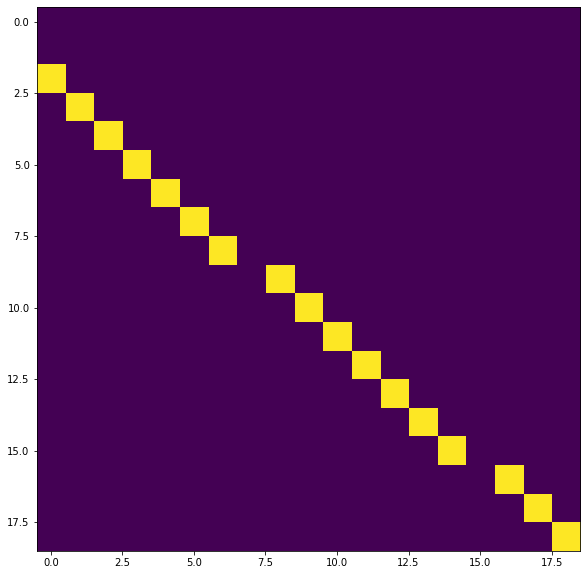

In [239]:
plt.figure(figsize=(10,10))
plt.imshow(filter)